In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import sys
import os

# Add the parent directory to sys.path so src can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import LinkNodeCommunity as linknode
from src.io.loader import load_macaque_fln_40d91

In [2]:
# Download the macaque FLN dataset from core-nets.org
edgelist, labels, regions, colors = load_macaque_fln_40d91(path="../data/macaque")

In [3]:
# Create directed graph from edge list
G = nx.DiGraph()
G.add_weighted_edges_from(edgelist[:, :3])

# Since the graph is directed and some nodes are only sources or only targets,
# we need to find the intersection of source and target nodes for clustering.
sources = set(u for u, _, _ in G.edges(data=True))
targets = set(v for _, v, _ in G.edges(data=True))
intersection_nodes = sources & targets
# Create a subgraph with only the intersection nodes
edge_complete_subgraph = G.subgraph(intersection_nodes)

In [4]:
# %%time
# We use the Hellinger similarity for directed graphs
# S = 1 - H^2, where H is the Hellinger distance
model = linknode.Clustering(G, similarity_index="hellinger_similarity", consider_subgraph=True)
model.fit_linksim_edgelist()

# We need to populate the link distance edgelist or matrix before processing features
# Here we use the edgelist approach

model.fit_linkdist_edgelist()

# NOTE: The dissimilarity matrix are in [0, 1], so max_dist should be set accordingly.
# Another option is to used the convert to a distance metric.
# For the Hellinger distance, sqrt(2)H is a proper distance metric.
# Since we use the single-linkage criterion to cluster links,
# the difference between using H or sqrt(2)H is negligible because of the monotonic transformation.

In [5]:
# %%time
# NOTE: To compute the link hierarchy statistics for downstream analysis,
# we need to extract the edge list from the edge-complete subgraph.
# Convert edge_complete_subgraph edges to a numpy array of shape (M, 3): [source, target, weight]

from src.LinkNodeCommunity.utils import edgelist_from_graph
model.edgelist = edgelist_from_graph(edge_complete_subgraph)

link_hierarchy_statistic = model.process_features_edgelist(max_dist=1.0) # max_dist for the squared Hellinger distance (H^2 = 1)

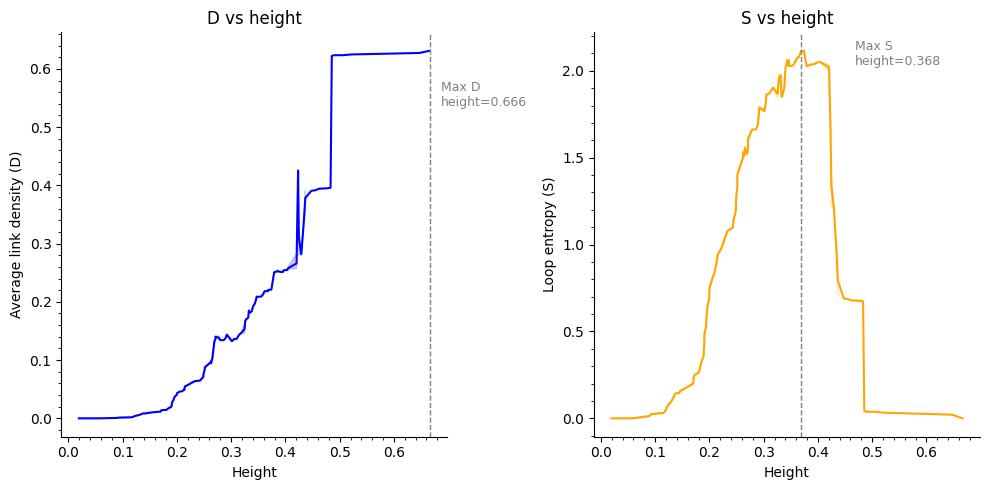

In [6]:
import matplotlib.pyplot as plt
from src.viz.graphics import link_statistics_graph

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
link_statistics_graph(
    link_stats=link_hierarchy_statistic,
    x="height",
    y="D",
    xlabel="Height",
    ylabel="Average link density (D)",
    testxoffset=0.02,
    color="blue",
    ax=axes[0]
)

link_statistics_graph(
    link_stats=link_hierarchy_statistic,
    x="height",
    y="S",
    xlabel="Height",
    ylabel="Loop entropy (S)",
    color="orange",
    ax=axes[1]
)
fig.tight_layout()
plt.show()

In [7]:
# %%time
# Get the node community hierarchy (linkage matrix Z)
# and linknode_equivalence to node hierarchy partition from
# link hierarchy statistics

model.node_community_hierarchy_edgelist(use_parallel=True, max_dist=1.0) # max_dist for the squared Hellinger distance (H^2 = 1)

In [8]:
# To visualize the node hierarchy as in the main paper,
# we need to convert the linkage matrix to Newick format
# and use R's ggtree package to plot it.

model.to_newick(labels=labels[:model.N])

%load_ext rpy2.ipython

# Prepare variables to pass into R
model_newick = model.newick
# Use the last merge height from the linkage matrix (column 2 in Python, 0-indexed)
root_position = 1 - model.Z[-1, 2]

ggtree v3.16.3 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

Guangchuang Yu. Using ggtree to visualize data on tree-like structures.
Current Protocols in Bioinformatics. 2020, 69:e96. doi:10.1002/cpbi.96

Attaching package: ‘ape’

The following object is masked from ‘package:ggtree’:

    rotate



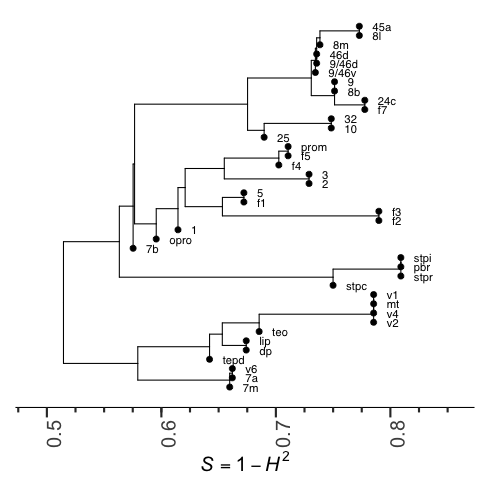

In [9]:
%%R -i model_newick -i root_position

library(ggplot2)
library(latex2exp)
library(ggtree)
library(grid)
library(ape)

# Build tree from Newick string passed in from Python
tree <- read.tree(text = model_newick)

offset <- 0.01

p <- ggtree(
  tree, layout = "rectangular", root.position = root_position
) +
  geom_tippoint(size = 2.5) +
  geom_tiplab(
    size = 4,
    angle = 0, offset = offset, hjust = 0
  )  +
  vexpand(0.025, direction = -1) +
  vexpand(0.025, direction = 1) +
  hexpand(0.025, direction = -1) +
  hexpand(0.05, direction = 1) +
  guides(
    x = guide_axis(minor.ticks = TRUE)
  ) +
  scale_x_continuous(minor_breaks = scales::breaks_width(0.025)) +
  theme_tree2(
    axis.text.x = element_text(size = 20, angle = 90),
    axis.ticks.length = unit(10, "pt"),
    axis.minor.ticks.length = unit(5, "pt"),
    axis.ticks.x = element_line(linewidth = 1),
    axis.ticks.length.x = unit(10, "pt"),
    axis.title.x = element_text(size = 20)
  ) +
  labs(x = TeX("$S=1-H^{2}$", italic = TRUE))

print(p)

In [10]:
# To visualize the partition at the Goldilock's level (maximum S),
# we find the corresponding height and use it to cut the tree.

from src.LinkNodeCommunity.utils import linknode_equivalence_partition

number_link_communities, \
    number_node_communities, \
        height_at_maximum = linknode_equivalence_partition(
            score="S",
            link_stats=link_hierarchy_statistic,
            linknode_equivalence=model.linknode_equivalence
        )
print(f"Number of link communities (K) at maximum S: {number_link_communities}")
print(f"Corresponding number of node communities (R): {number_node_communities}")
print(f"Height at maximum S: {height_at_maximum}")

Number of link communities (K) at maximum S: 56
Corresponding number of node communities (R): 9
Height at maximum S: 0.3682297190969932


In [11]:
# Cut the tree at the height corresponding to maximum S
from src.LinkNodeCommunity.utils import cut_tree_with_validation, collapsed_partition

node_partition = cut_tree_with_validation(model.Z, number_node_communities)
node_partition = collapsed_partition(node_partition)  # Collapse to consecutive integers starting from 0

# Compute NOCs using the node partition
nocs_model = linknode.NOCFinder(
    edge_complete_subgraph, node_partition,
    undirected=False,
    labels=labels[:model.N],
    similarity_index="hellinger_similarity",
    tie_policy="include_equal"
)

# Fit the NOC model using the precomputed link similarity matrices
# It will populate the NOC attributes
nocs_model.fit(model.linksim.source_sim_matrix, model.linksim.target_sim_matrix)

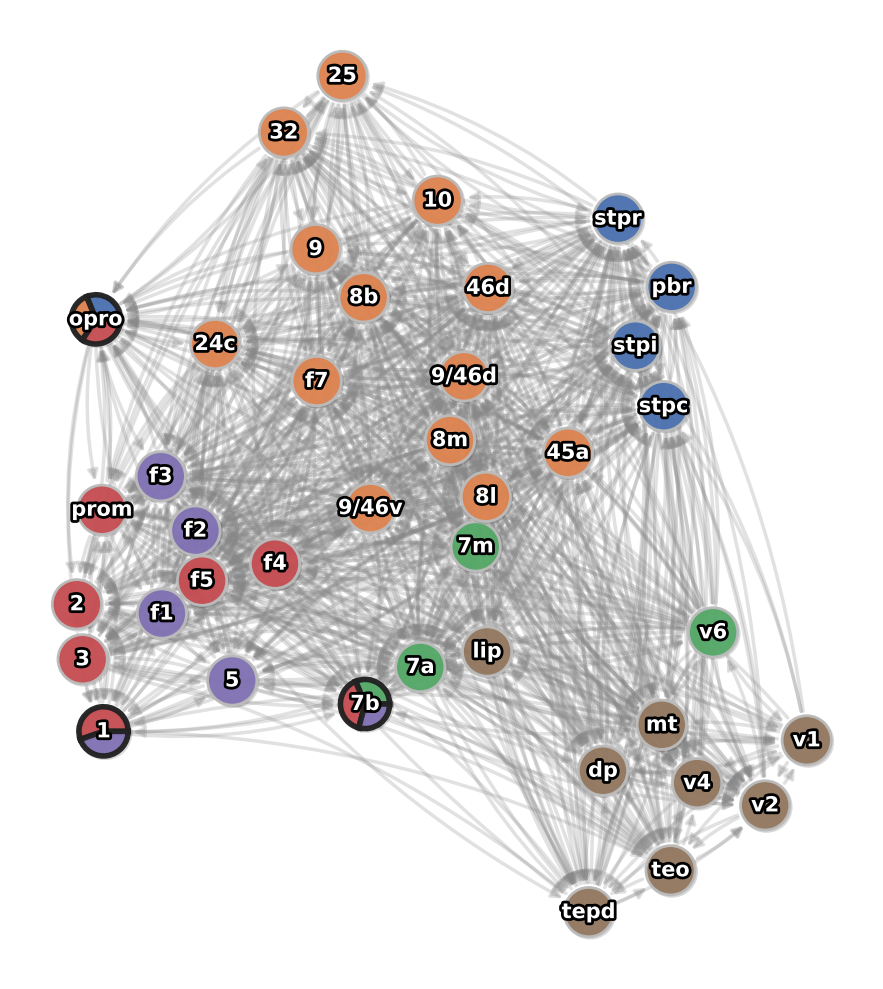

In [12]:
# Visualize the NOCs on a 2D network layout

from src.viz.graphics import graph_network_covers

label_offsets = {
    "v1": np.array([0.05, 0]),
    "v2": np.array([0, -0.1]),
    "46d": np.array([0.05, 0.05]),
    "9/46d": np.array([0, -0.05]),
    "f4": np.array([0.05, 0.05])
}

# Transform edge weights for layout computation
G_dist = edge_complete_subgraph.copy()
for _, _, d in G_dist.edges(data=True):
    w = d.get("weight", 1.0)
    # Avoid log(0) or negative/zero weights
    w = max(w, 1e-10)
    d["distance"] = -np.log(w)

# Use -log(w) as the distance for kamada_kawai_layout
pos = nx.kamada_kawai_layout(
    G_dist, 
    weight="distance"
)

fig, ax = plt.subplots(figsize=(10, 10))

graph_network_covers(
    G_dist,
    pos,
    nocs_model.node_cover_partition,
    node_partition,
    nocs_model.single_node_cover_map,
    nocs_model.single_nodes_cover_scores,
    labels=labels[:model.N],
    palette="deep",
    figsize=(10, 10), scale=0.8, arrowsize=15,
    font_size=15, stroke_linewidth=4, hide_labels=False,
    label_offsets=label_offsets,
    ax=ax
)


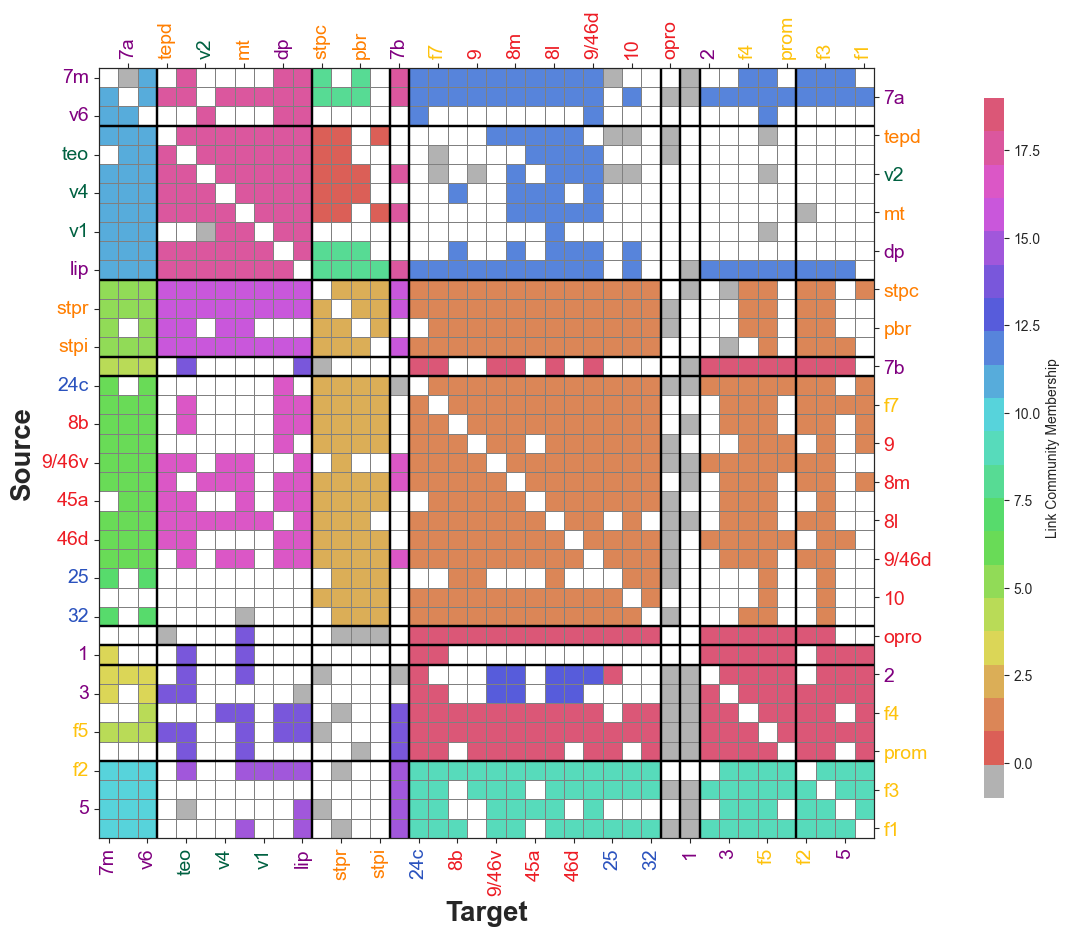

In [13]:
# Finally, visualize the link community matrix at the Goldilock's level
from src.viz.graphics import linkcommunity_matrix_map

linkcommunity_matrix_map(
    edge_complete_subgraph,
    model.get_hierarchy_edgelist(1.0),
    model.Z,
    number_link_communities,
    number_node_communities,
    labels=labels[:model.N],
    colors=colors[:model.N],
    linewidth=1.75,
    palette="hls",
)